In [3]:
%matplotlib inline
import os
import time
import h5py
import pygpc
import warnings
import numpy as np
import matplotlib.cbook
import matplotlib.pyplot as plt
from collections import OrderedDict
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

## Gradient enhanced gPC
It is possible to accelerate the identification of the gPC coefficients by using the derivative information of the transfer function. The gPC matrix consists of continuously differentiable polynomials and can be extended by its partial derivatives at each sampling point. This extends the resulting system of equations to:

$$
\left[ \begin{array}{c}
\mathbf{\Psi}\\                                              
\mathbf{\Psi}_\partial                                             
\end{array}\right]
[\mathbf{U}] =
\left[ \begin{array}{c}
\mathbf{Y}\\                                              
\mathbf{Y}_\partial                                             
\end{array}\right],
$$

where the gradient gPC matrix $[\mathbf{\Psi}_\partial]$ is of size $[d N_g \times N_c]$ and contains the partial derivatives of the basis functions at each sampling point:

$$
[\mathbf{\Psi}_\partial] = 
\left[ \begin{array}{c}
\left.\frac{\partial\psi}{\partial\xi_1}\right|_{\xi_1}\\                                              
\vdots\\
\left.\frac{\partial\psi}{\partial\xi_d}\right|_{\xi_1}\\
\vdots\\
\vdots\\
\vdots\\
\left.\frac{\partial\psi}{\partial\xi_1}\right|_{\xi_{N_g}}\\                                              
\vdots\\
\left.\frac{\partial\psi}{\partial\xi_d}\right|_{\xi_{N_g}}
\end{array}\right]
$$

The solution on the right hand side is extended accordingly:

$$
[\mathbf{Y}_\partial] = 
\left[ \begin{array}{ccc}
\left.\frac{\partial y_1}{\partial\xi_1}\right|_{\xi_1} & \ldots & \left.\frac{\partial y_{N_q}}{\partial\xi_1}\right|_{\xi_1}\\                                              
\vdots & \vdots & \vdots\\
\left.\frac{\partial y_1}{\partial\xi_d}\right|_{\xi_1} & \ldots & \left.\frac{\partial y_{N_q}}{\partial\xi_d}\right|_{\xi_1}\\
\vdots & \ldots & \vdots\\
\vdots & \ddots & \vdots\\
\vdots & \ldots & \vdots\\
\left.\frac{\partial y_1}{\partial\xi_1}\right|_{\xi_{N_g}} & \ldots & \left.\frac{\partial y_{N_q}}{\partial\xi_1}\right|_{\xi_{N_g}}\\                                              
\vdots & \vdots & \vdots\\
\left.\frac{\partial y_1}{\partial\xi_d}\right|_{\xi_{N_g}} & \ldots & \left.\frac{\partial y_{N_q}}{\partial\xi_d}\right|_{\xi_{N_g}}
\end{array}\right]
$$

The complete system now reads:

$$
[\mathbf{\Psi}'][\mathbf{U}] = [\mathbf{Y}']
$$

This gradient based formulation consists of $(d+1) N_g$ equations that match both function values and gradients, in comparison to traditional approaches which consists of only $N_g$ equations that match function values. Despite the extra computational cost required to obtain the gradients, the use of gradients improves the gPC. However, there exist several methods to determine the gradients. In the following, the implemented methods in pygpc are presented and compared. 


### Gradient estimation of sparse irregular datasets
Surface interpolation finds application in many aspects of science and technology.
A typical application in geological science and environmental engineering is to contour surfaces from hydraulic head measurements from irregular spaced data.

Computing gradients efficiently and accurately from sparse irregular high-dimensional datasets is challenging. The additional calculation effort should be kept as low as possible, especially in the case of computationally expensive models

### Finite difference approach using forward approximation
Let $f:D \subset \mathbb{R}^d \rightarrow \mathbb{R}$ be differentiable at $\mathbf{x}_0 \in D$. Taylor's theorem for several variables states that:

$$
f(\mathbf{x}_0 + \mathbf{h}) = f(\mathbf{x}_0) + \frac{(\mathbf{h} \cdot \nabla)f(\mathbf{x}_0)}{1!} + ... + \frac{(\mathbf{h} \cdot \nabla)^rf(\mathbf{x}_0)}{r!} + R_r
$$

where the remainder $R_r$ has the Lagrange form:

$$
\frac{(\mathbf{h} \cdot \nabla)^{r+1} f(\mathbf{x}_0 + \theta \mathbf{h})}{(r+1)!}
$$

Truncating the Taylor series after the first term leads to:

$$
\nabla f(\mathbf{x}_0) = \frac{f(\mathbf{x}_0 + \mathbf{h}) - f(\mathbf{x}_0)}{\left\lVert\mathbf{h}\right\lVert}
$$

In order to approximate the gradient it is necessary to determine addtitional function values $f(\mathbf{x}_0 + \mathbf{h})$ at small displacements $\mathbf{h}$ in every dimension. Each additional row in the gradient gPC matrix $[\mathbf{\Psi}_\partial]$ thus requires one additional model evaluation.

<div>
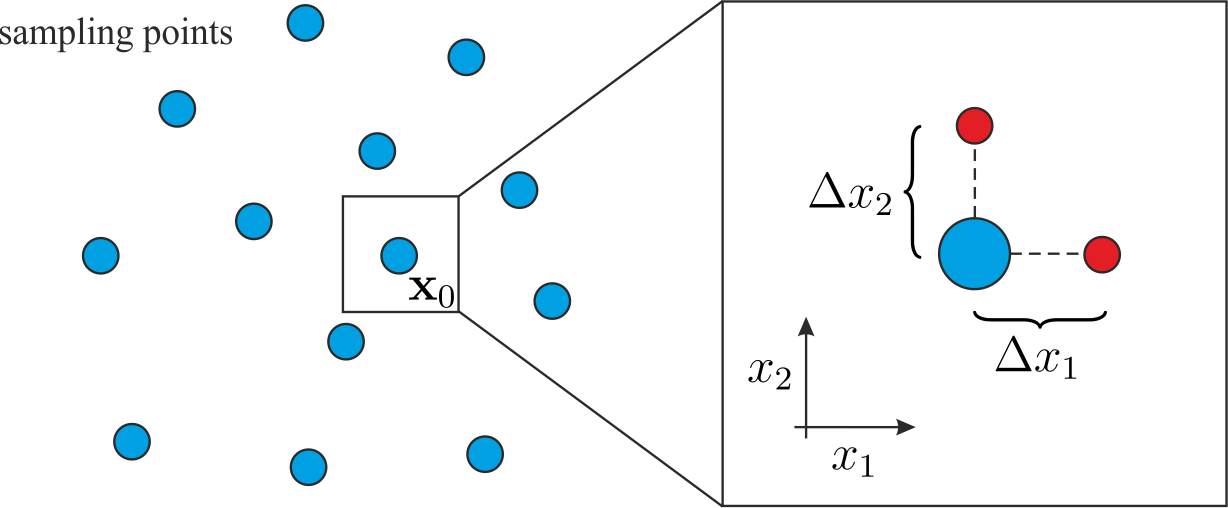
</div>

This torpedoes the previously mentioned advantage of the gradient enhanced gPC approach in terms of efficacy.

### Finite difference regression approach of 1st order accuracy
Suppose that $\mathbf{x}_0=(x_1, ..., x_d)^\mathrm{T}$ is the point where we want to estimate the gradient and we are given $p$ scattered data points $\mathbf{x}_i = (x_{1,i}, ..., x_{d,i}), i = 1, ..., p$, which are located closely to $\mathbf{x}_0$ such that $\mathbf{x}_i \in \mathcal{B}_\delta(\mathbf{x}_0)$.

<div>
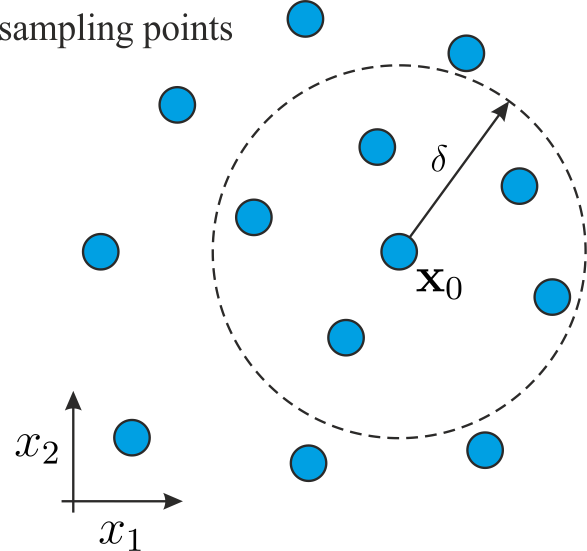
</div>

Truncating the Taylor expansion after the first term allows to write an overdetermined system of equations for $\mathbf{g}=\left(\frac{\partial f}{\partial x_1}, ... , \frac{\partial f}{\partial x_d} \right)^\mathrm{T}$ in the form:

$$
[\mathbf{D}] \mathbf{g} = \delta\mathbf{f}
$$

whose least squares solution provides a first order estimate of the gradient. The matrix $\mathbf{D}\in\mathbb{R}^{p \times d}$ contains the distances between the surrounding points $\mathbf{x}_i$ and the point $\mathbf{x}_0$ and is given by:

$$
[\mathbf{D}] = 
\left[ \begin{array}{ccc}
(x_{1,1} - x_{1,0}) & \ldots & (x_{d,1} - x_{d,0}) \\
\vdots & \ddots & \vdots \\
(x_{1,p} - x_{1,0}) & \ldots & (x_{d,p} - x_{d,0})
\end{array}\right]
=
\left[ \begin{array}{ccc}
\delta x_{1,1} & \ldots & \delta x_{d,1} \\
\vdots & \ddots & \vdots \\
\delta x_{1,p} & \ldots & \delta x_{d,p} 
\end{array}\right]
$$

The differences of the model solutions $\delta f_i = f(\mathbf{x}_0 + \delta\mathbf{x}_i)-f(\mathbf{x}_0) $ are collected in the vector $\delta \mathbf{f} \in \mathbb{R}^{p \times 1}$.

Each adjacent point may be weighted by its distance to $\mathbf{x}_0$. This can be done by introducing a weight matrix $[\mathbf{W}] = \mathrm{diag}(\left\lvert\delta\mathbf{x}_1\right\lvert^{\alpha}, ..., \left\lvert\delta\mathbf{x}_p\right\lvert^{\alpha})$ with $\alpha=-1$ for inverse distance or $\alpha=-2$ for inverse distance squared.

$$
[\mathbf{W}][\mathbf{D}] \mathbf{g} = [\mathbf{W}]\delta\mathbf{f}
$$

The least squares solution of the gradient is then given by:

$$
\mathbf{g} = \left([\mathbf{W}][\mathbf{D}]\right)^+[\mathbf{W}]\delta\mathbf{f}
$$

This procedure has to be repeated for every sampling point $\mathbf{x}_0$. With this approach, it is possible to estimate the gradients only from the available data points without the need to run additional simulations. However, one has to suitably choose the values of $\delta$ and $\alpha$. If the sampling points are too far away from each other, it may not be possible to estimate the gradient accurately.

### Finite difference regression approach of 2nd order accuracy
Truncating the Taylor expansion after the second term enables the following overdetermined system to be solved, in the least squared sense, to obtain a second order approximation for the gradient:

$$
[\mathbf{D}:\mathbf{M}]\left[ \begin{array}{c}
\mathbf{g}\\
\mathbf{z}\\
\end{array}\right]=
\delta \mathbf{f}
$$

where the second order distance matrix $[\mathbf{M}] \in \mathbb{R}^{p \times \sum_{i=1}^{d} i}$ given by:

$$
[\mathbf{M}]=
\left[\begin{array}{cccc}
\frac{1}{2}\delta x_{1,1}^2 & \delta x_{1,1} \delta x_{2,1} & \ldots & \frac{1}{2}\delta x_{d,1}^2\\
\vdots & \ldots & \ldots & \vdots \\
\frac{1}{2}\delta x_{1,p}^2 & \delta x_{1,p} \delta x_{2,p} & \ldots & \frac{1}{2}\delta x_{d,p}^2\\
\end{array}\right]
$$

The vector $\mathbf{z}=\left(\frac{\partial^2 f}{\partial x_1^2}, \frac{\partial^2 f}{\partial x_1 x_2} , ..., \frac{\partial^2 f}{\partial x_d^2}\right)^\mathrm{T}$ contains the second derivatives. The new system of equations can be written as:

$$
[\mathbf{D}] \mathbf{g} = \delta\mathbf{f} - [\mathbf{M}] \mathbf{z}
$$

Applying the weight matrix $[\mathbf{W}] = \mathrm{diag}(\left\lvert\delta\mathbf{x}_1\right\lvert^{\alpha}, ..., \left\lvert\delta\mathbf{x}_p\right\lvert^{\alpha})$ leads:

$$
[\mathbf{W}][\mathbf{D}] \mathbf{g} = [\mathbf{W}]\delta\mathbf{f} - [\mathbf{W}][\mathbf{M}] \mathbf{z}
$$

from which it can be seen that a more accurate estimate of the gradient than that offered as the previous approach can be obtained if the second order derivative terms are eliminated from the system. This elimination can be performed using QR decomposition of $[\mathbf{W}][\mathbf{M}]$, namely $[\mathbf{Q}]^{\mathrm{T}}[\mathbf{W}][\mathbf{M}] = [\mathbf{T}]$ with $[\mathbf{Q}]^{\mathrm{T}} \in \mathbb{R}^{p \times p}$ and $[\mathbf{T}]\in \mathbb{R}^{p \times \sum_{i=1}^{d} i}$, which has upper trapezoidal form. Applying $[\mathbf{Q}]^{\mathrm{T}}$ to the system of equations leads:

$$
[\mathbf{Q}]^{\mathrm{T}}[\mathbf{W}][\mathbf{D}] \mathbf{g} = [\mathbf{Q}]^{\mathrm{T}}[\mathbf{W}]\delta\mathbf{f} - [\mathbf{T}]\mathbf{z}
$$

Because $[\mathbf{T}]$ is of upper trapezoidal form, one can eliminate the influence of the second order derivatives in $\mathbf{z}$ by discarding the first $\sum_{i=1}^{d} i$ equations. The least square solution of the remaining $p-\sum_{i=1}^{d} i$ equations then provides a second order accurate estimate of the gradient $\mathbf{g}$.

$$
\mathbf{g} = \left( [\mathbf{Q}]^{\mathrm{T}}[\mathbf{W}][\mathbf{D}] \right)^+[\mathbf{Q}]^{\mathrm{T}}[\mathbf{W}]\delta\mathbf{f}
$$

This approach is more accurate than the first order approximation but needs more sampling points because of reduction of the system.

<div>
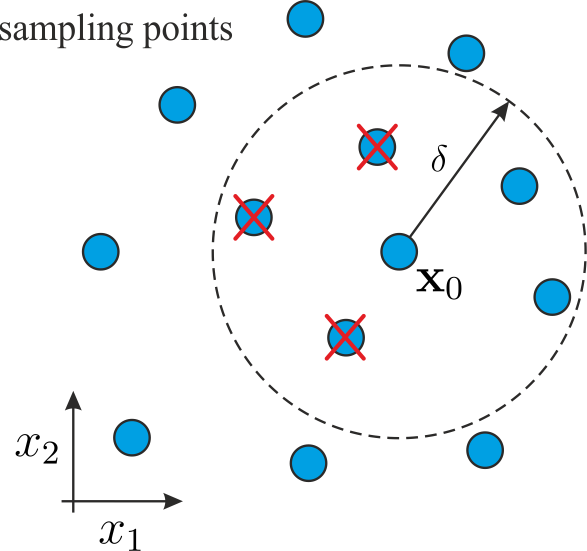
</div>

Although the initial thought might be that the ordering of the equations would have some impact on the gradient estimation process, this is indeed not the case. To see why, let $[\mathbf{R}] \in \mathbb{R}^{p \times p}$ be a perturbation matrix that permutes the rows of $[\mathbf{W}][\mathbf{M}]$. Because the orthogonal reduction of $[\mathbf{W}][\mathbf{M}]$ produces unique matrices $[\mathbf{Q}]$ and $[\mathbf{T}]$ such that $[\mathbf{Q}]^{\mathrm{T}}[\mathbf{W}][\mathbf{M}] = [\mathbf{T}]$ it follows that applying orthogonal reduction to the permuted system $[\mathbf{R}][\mathbf{W}][\mathbf{M}]\mathbf{x} = \delta \mathbf{f}$ yields with $[\tilde{\mathbf{Q}}]^{\mathrm{T}}[\mathbf{R}][\mathbf{W}][\mathbf{M}] = [\mathbf{T}]$ and $[\mathbf{Q}] = [\mathbf{R}]^\mathrm{T}[\tilde{\mathbf{Q}}]$ exactly the same system as before.